In this first part, we install import all the packages used

In [1]:
#Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Subpackages
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix



#ImportFunctions
from Functions import fetch_data
from Functions import moving_average
from Functions import rsi
from Functions import macd
from Functions import lagged_return
from Functions import bollinger_bands
from Functions import pe_ratio
from Functions import daily_returns



In [2]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

# Ensure that TensorFlow is using GPU (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Check TensorFlow version for reference
print("TensorFlow Version:", tf.__version__)

No GPU found. Using CPU.
TensorFlow Version: 2.14.0


Next, we import some stock data

In [3]:
tickers = ["AAPL"]
start_date = "2015-01-01"
end_date = "2023-01-01"

stock_data = fetch_data(tickers, start_date, end_date)

Now we calculate the technical indicators for each stock

In [4]:
# For each stock's data, compute the technical indicators and add them as new columns to the DataFrame

for ticker, data in stock_data.items():
    # Backup the 'Close' prices
    close_prices = data['Close'].copy()
    
    # 20-day Moving Average
    data['MA20'] = moving_average(data)
    
    # RSI
    data['RSI'] = rsi(data)
    
    # MACD
    data['MACD'], data['Signal_Line'] = macd(data)
    
    # 1, 2, and 3 Day Lagged Returns
    data['Lagged_Return_1'] = lagged_return(data, 2)
    data['Lagged_Return_2'] = lagged_return(data, 3)
    data['Lagged_Return_3'] = lagged_return(data, 4)
    
    # Bollinger Bands
    data['Upper_Bollinger'], data['Lower_Bollinger'] = bollinger_bands(data)
    
    # Restore 'Close' column
    data['Close'] = close_prices

    # Extract the 'Close' column
    close_prices = data['Close']
    
    # Calculate daily returns for all available days
    daily_returns = close_prices.pct_change().dropna()

    



Now that we have all the technical indicators for each stock we make a new dataframe that contains the data for all the stocks. We also do some data cleaning like removing the NANs. 

In [5]:
# Dictionary to store the split data for each stock
all_stock_data = {}

for ticker, data in stock_data.items():
    data_clean = data.dropna()  # drop rows with NaN values

    # Features: using technical indicators and lagged returns
    X = data_clean[['RSI', 'MACD', 'Signal_Line', 'Lagged_Return_1', 'Lagged_Return_2', 'Lagged_Return_3', 'Upper_Bollinger', 'Lower_Bollinger']]

    # Target: Direction of the next day's return (1 for positive, 0 for negative or non-positive)
    y = (data_clean['Close'].pct_change().shift(-1) > 0).astype(int)

    # Splitting the data: 70% train, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

    # Store the index right after splitting
    X_test_index = X_test.index

    
    # Store the data splits in the dictionary
    all_stock_data[ticker] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

# Now, `all_stock_data` contains the data splits for all stocks.

Now, we normalize the data to pe ready for Neural network

In [6]:
from sklearn.preprocessing import StandardScaler

# Iterate over each stock's data
for ticker, data_splits in all_stock_data.items():
    scaler = StandardScaler()

    # Fit the scaler only on the training data
    data_splits['X_train'] = scaler.fit_transform(data_splits['X_train'])
    
    # Transform the validation and test data using the scaler
    data_splits['X_val'] = scaler.transform(data_splits['X_val'])
    data_splits['X_test'] = scaler.transform(data_splits['X_test'])

    # Update the dictionary with normalized data
    all_stock_data[ticker] = data_splits


Now we actually make the classifier to predict the stock direction. We use a random forest model to determine this.

In [7]:
# Required TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Dictionary to store the trained models and their performances
models = {}
performances = {}

# List to store all validation accuracy scores
all_validation_accuracies = []

for ticker in all_stock_data:
    # Get data for the current stock
    X_train = all_stock_data[ticker]['X_train']
    y_train = all_stock_data[ticker]['y_train']
    X_val = all_stock_data[ticker]['X_val']
    y_val = all_stock_data[ticker]['y_val']

    # Define the neural network model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Validate the model
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    # Predict the validation data
    y_val_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
    
    # Add the accuracy to the list
    all_validation_accuracies.append(accuracy)

    # Store the trained model and its performance
    models[ticker] = model
    performances[ticker] = {
        'Accuracy': accuracy,
        'Classification Report': classification_report(y_val, y_val_pred)
    }

    # Print out the performance for the current stock
    print(f"Performance for {ticker}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_val_pred))
    print("-------------------------------------------------")

# Calculate and print the average validation accuracy
average_validation_accuracy = sum(all_validation_accuracies) / len(all_validation_accuracies)
print(f"Average Validation Accuracy across all stocks: {average_validation_accuracy:.4f}")


10/10 [==============================] - 0s 2ms/step
Performance for AAPL:
Accuracy: 0.5017
              precision    recall  f1-score   support

           0       0.48      0.49      0.48       142
           1       0.53      0.51      0.52       157

    accuracy                           0.50       299
   macro avg       0.50      0.50      0.50       299
weighted avg       0.50      0.50      0.50       299

-------------------------------------------------
Average Validation Accuracy across all stocks: 0.5017


After we have trained the model on the validation set, we will now test on an out of sample test. In other words, we test on new data.

In [8]:
# Dictionary to store test set performances
test_performances = {}

# List to store all accuracy scores
all_accuracies = []

for ticker in all_stock_data:
    # Get the test data for the current stock
    X_test = all_stock_data[ticker]['X_test']
    y_test = all_stock_data[ticker]['y_test']

    # Predict using the trained model
    y_test_pred_probs = models[ticker].predict(X_test)
    y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to class labels
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store the performance on the test set
    test_performances[ticker] = {
        'Test Accuracy': test_accuracy,
        'Test Classification Report': classification_report(y_test, y_test_pred)
    }

    # Add the accuracy to the list
    all_accuracies.append(test_accuracy)

    # Print out the test performance for the current stock
    print(f"Test Performance for {ticker}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print("-------------------------------------------------")

# Calculate and print the average accuracy
average_accuracy = sum(all_accuracies) / len(all_accuracies)
print(f"Average Test Accuracy across all stocks: {average_accuracy:.4f}")


10/10 [==============================] - 0s 4ms/step
Test Performance for AAPL:
Test Accuracy: 0.4933
              precision    recall  f1-score   support

           0       0.51      0.70      0.59       155
           1       0.46      0.28      0.34       145

    accuracy                           0.49       300
   macro avg       0.48      0.49      0.47       300
weighted avg       0.48      0.49      0.47       300

-------------------------------------------------
Average Test Accuracy across all stocks: 0.4933


Now we start backtesting the models. We make a list that includes the predicted return and the actual return.

In [9]:
ReturnsAndPredictionStocks = {}
ReturnsAndPredictionsValueNN = []
Daily_return_Value = []
Date = []

for ticker, stock_data in all_stock_data.items():
    
    # Get the test data for the current stock
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    Returndata = data['Close']

    # Calculate the daily returns
    daily_returns = Returndata.pct_change()
    
    # Drop the first NaN value (since there is no return for the first day)
    daily_returns = daily_returns.dropna()

    # Predict using the neural network model
    y_test_pred_nn = (models[ticker].predict(X_test) > 0.5).astype(int).flatten() 

    # Add the daily returns to a list
    Daily_return_Value.append(daily_returns.tolist())
    
    # Add the results to a list and adding date
    ReturnsAndPredictionsValueNN.append(y_test_pred_nn)

    # Store the prediction and test for the model
    ReturnsAndPredictionStocks[ticker] = {
        'daily return': daily_returns,
        'prediction for neural network': y_test_pred_nn
    }


 1/10 [==>...........................] - ETA: 0s

10/10 [==============================] - 0s 3ms/step


In [10]:
for ticker, stock_data in all_stock_data.items():
    
    # Create an empty DataFrame for each stock
    df = pd.DataFrame(columns=['Date', 'daily return', 'Neural Network'])

    # Get the test data for the current stock
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    Returndata = data['Close']

    # Calculate the daily returns for the current stock
    daily_returns = Returndata.pct_change()
    
    # Align daily_returns with X_test and y_test
    daily_returns = daily_returns.loc[X_test_index]


    # Predict using the neural network model
    y_test_pred_nn = (models[ticker].predict(X_test) > 0.5).astype(int).flatten()

    # Create a DataFrame for the current stock
    ResultsReturnAndPrediction = pd.DataFrame({
        'Date': X_test_index,
        'daily return': daily_returns.tolist(),
        'Neural Network': y_test_pred_nn.tolist()
    })

    # Append the stock DataFrame to the main DataFrame
    df = pd.concat([df, ResultsReturnAndPrediction], ignore_index=True)

    # Drop rows with NaN values in any column
    df = df.dropna()

    # Print the resulting DataFrame for each stock
    print(f"Data for {ticker}:")
    print(df)

10/10 [==============================] - 0s 3ms/step
Data for AAPL:
          Date  daily return Neural Network
0   2021-10-22     -0.005285              0
1   2021-10-25     -0.000336              0
2   2021-10-26      0.004575              0
3   2021-10-27     -0.003148              0
4   2021-10-28      0.024992              0
..         ...           ...            ...
295 2022-12-23     -0.002798              0
296 2022-12-27     -0.013878              0
297 2022-12-28     -0.030685              0
298 2022-12-29      0.028324              0
299 2022-12-30      0.002469              0

[300 rows x 3 columns]


We perform the backtest and plot the results

10/10 [==============================] - 0s 4ms/step


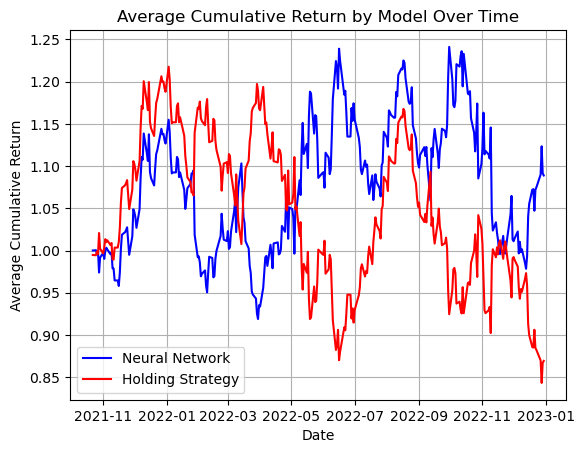

In [11]:
# DataFrames to store cumulative returns time series for all stocks
df_cumulative_returns_nn = pd.DataFrame(index=X_test_index)  # Using X_test_index
df_daily_returns_all_stocks = pd.DataFrame(index=X_test_index)  # DataFrame to store daily returns for all stocks

for ticker, stock_data in all_stock_data.items():
    
    # Extract the test data and the returns data
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    Returndata = data['Close']
    daily_returns = Returndata.pct_change().loc[X_test_index]  # Using X_test_index
    df_daily_returns_all_stocks[ticker] = daily_returns  # Store daily returns for each stock

    # Predict using the neural network model
    y_test_pred_nn = (models[ticker].predict(X_test) > 0.5).astype(int).flatten()
    
    #
    y_test_pred_nn_series = pd.Series(y_test_pred_nn, index=X_test_index)
    y_test_pred_nn_shifted = y_test_pred_nn_series.shift(1).fillna(0)

    
    # Calculate strategy daily returns based on the shifted predictions
    strategy_returns_nn = daily_returns * (2 * y_test_pred_nn_shifted - 1)

    # Set the first value of strategy returns to 0 to ensure cumulative product starts at 1
    strategy_returns_nn.iloc[0] = 0

    # Calculate cumulative returns time series
    df_cumulative_returns_nn[ticker] = (1 + strategy_returns_nn).cumprod()

# Calculate average daily returns across all stocks
average_daily_returns = df_daily_returns_all_stocks.mean(axis=1)

# Calculate cumulative returns for holding strategy
cumulative_returns_holding = (1 + average_daily_returns).cumprod()

# Calculate average cumulative returns for each date
avg_cumulative_returns_nn = df_cumulative_returns_nn.mean(axis=1)

# Plotting the results
plt.plot(avg_cumulative_returns_nn, label='Neural Network', color='blue')
plt.plot(cumulative_returns_holding, label='Holding Strategy', color='red')  # Add this line
plt.xlabel('Date')
plt.ylabel('Average Cumulative Return')
plt.title('Average Cumulative Return by Model Over Time')
plt.legend()
plt.grid(True)
plt.show()


Now we calculate the sharpe ratios from the 3 strategies

In [12]:
# Calculate daily returns for the neural network strategy
daily_returns_nn = df_cumulative_returns_nn.pct_change().mean(axis=1)

# 1. Calculate the mean daily return for each strategy
mean_return_nn = daily_returns_nn.mean()
mean_return_holding = average_daily_returns.mean()

# 2. Calculate the standard deviation of daily returns for each strategy
std_dev_nn = daily_returns_nn.std()
std_dev_holding = average_daily_returns.std()

# 3. Compute the Sharpe ratio for each strategy (assuming risk-free rate is 0)
sharpe_ratio_nn = mean_return_nn / std_dev_nn
sharpe_ratio_holding = mean_return_holding / std_dev_holding

print(f"Sharpe Ratio (Neural Network): {sharpe_ratio_nn:.4f}")
print(f"Sharpe Ratio (Holding Strategy): {sharpe_ratio_holding:.4f}")


Sharpe Ratio (Neural Network): 0.0240
Sharpe Ratio (Holding Strategy): -0.0109


In the plot above we have the most important features of the simple nontuned model.

10/10 [==============================] - 0s 3ms/step


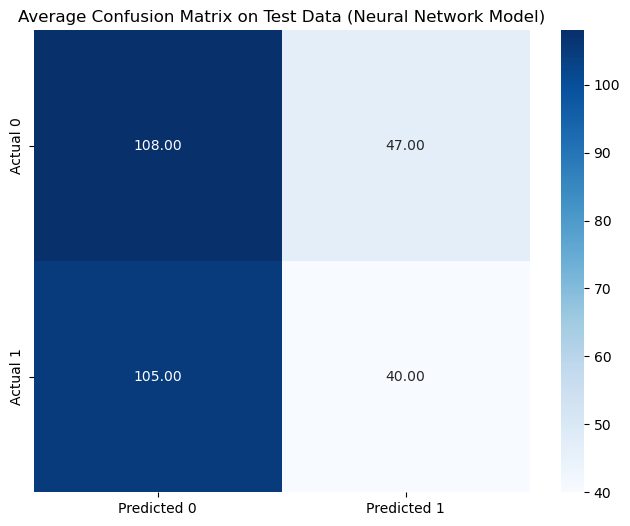

In [13]:
# Initialize a cumulative confusion matrix with zeros
cumulative_cm = np.zeros((2, 2))

# Loop through each stock ticker in the models dictionary
for ticker, model in models.items():
    X_test = all_stock_data[ticker]['X_test']
    y_test = all_stock_data[ticker]['y_test']
    
    # Get predictions on the test set
    y_test_pred = (model.predict(X_test) > 0.5).astype(int).flatten()  # Threshold the predictions to get class labels
    
    # Add the confusion matrix for the current stock to the cumulative matrix
    cumulative_cm += confusion_matrix(y_test, y_test_pred)

# Calculate the average confusion matrix
average_cm = cumulative_cm / len(models)

# Plot the average confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Average Confusion Matrix on Test Data (Neural Network Model)")
plt.show()
